# Extracting image data from pdz files 

> Good to know where we took the measurement...

In [ ]:
#|default_exp jpg_extractor 

In [ ]:
#|hide 
import os 
from glob import glob

In [ ]:
#|hide 
# file 14 is the older type 1
pdz_files = sorted(glob('/home/frank/Work/DATA/read-pdz-demodata/*.pdz'))
list(enumerate(pdz_files))

[(0, '/home/frank/Work/DATA/read-pdz-demodata/00066-Spectrum Only.pdz'),
 (1, '/home/frank/Work/DATA/read-pdz-demodata/00067-Spectrum Only.pdz'),
 (2, '/home/frank/Work/DATA/read-pdz-demodata/00068-Alloys 2.pdz'),
 (3, '/home/frank/Work/DATA/read-pdz-demodata/00069-Alloys 2.pdz'),
 (4, '/home/frank/Work/DATA/read-pdz-demodata/00081-Precious Metals 2.pdz'),
 (5, '/home/frank/Work/DATA/read-pdz-demodata/00085-Mudrock Dual.pdz'),
 (6, '/home/frank/Work/DATA/read-pdz-demodata/00086-Mudrock Dual.pdz'),
 (7, '/home/frank/Work/DATA/read-pdz-demodata/00181-Restricted Materials.pdz'),
 (8, '/home/frank/Work/DATA/read-pdz-demodata/00182-Restricted Materials.pdz'),
 (9, '/home/frank/Work/DATA/read-pdz-demodata/1-sky sample spot.pdz'),
 (10, '/home/frank/Work/DATA/read-pdz-demodata/2-sky left of left tree.pdz'),
 (11,
  '/home/frank/Work/DATA/read-pdz-demodata/3-brown left edge sample spot.pdz'),
 (12, '/home/frank/Work/DATA/read-pdz-demodata/ANALYZE_EMP-10.pdz'),
 (13, '/home/frank/Work/DATA/read

The newest Bruker Tracer XRF spectrometers are equipped with a simple RGB camera that can be used to record the location of the spectral measurement. These RGB images are then encoded as jpg binary data that are stored within a single specific block (type 137) in the pdz file. If a pdz file actually contains one or more sets of image data you can use the `extract_jpg()` function to get them out. 

In [ ]:
from read_pdz import extract_jpg 

In [ ]:
pdz_file = '/home/frank/Work/DATA/read-pdz-demodata/00081-Precious Metals 2.pdz' # contains jpg image 
ims = extract_jpg(pdz_file, save_file=True)

Saving image file: '/home/frank/Work/DATA/read-pdz-demodata/00081-Precious Metals 2-0.jpg'


Let's take a look at the image. Can anyone tell what we see here? 

In [ ]:
#|code-fold: true 
import matplotlib.pyplot as plt  

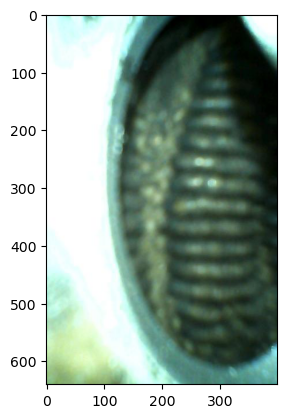

In [ ]:
#|code-fold: true
fig, ax = plt.subplots()
ax.imshow(ims[0]);

Some pdz files contain multiple images. Let's see how they look like. 

In [ ]:
pdz_file = '/home/frank/Work/DATA/read-pdz-demodata/with-three-images.pdz' 
ims = extract_jpg(pdz_file, save_file=True)

Saving image file: '/home/frank/Work/DATA/read-pdz-demodata/with-three-images-0.jpg'
Saving image file: '/home/frank/Work/DATA/read-pdz-demodata/with-three-images-1.jpg'
Saving image file: '/home/frank/Work/DATA/read-pdz-demodata/with-three-images-2.jpg'


In [ ]:
#|code-fold: true 
import matplotlib.pyplot as plt  

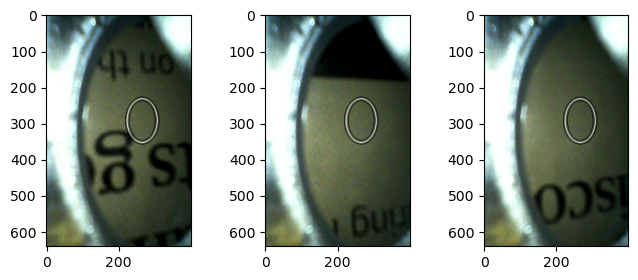

In [ ]:
#|code-fold: true
fig, axs = plt.subplots(ncols=3, figsize=[8, 3], squeeze=True)

for im, ax in zip(ims, axs): 
    ax.imshow(im)

## FUNCTIONS 

In [ ]:
#|export 

from read_pdz import file_to_bytes, get_blocks, get_blocktypes 
import numpy as np 
import io 
import re
import matplotlib.pyplot as plt 
from PIL import Image

In [ ]:
#|export 

def extract_jpg(pdz_file, BLOCKTYPE=137, save_file=False):
    '''Extract and save jpg images from `pdz_file`.
    
    Returns a list of jpg images where ims = [ im0, im1, ... ].
    '''

    # parse into blocks
    pdz_bytes = file_to_bytes(pdz_file)
    block_list = get_blocks(pdz_bytes, verbose=False)

    # read block 137 (if present)

    blocktypes_list = get_blocktypes(block_list)

    if BLOCKTYPE not in blocktypes_list:

        print(f'Could not find jpg image data in: {pdz_file}')

    else:
        jpg_i = blocktypes_list.index(BLOCKTYPE)
        jpg_dict = block_list[jpg_i]

        jpg_sandwich = jpg_dict['bytes'].tobytes()

        # code below thanks to Lars Maxfield
        # Repeatedly search for jpgs by consuming jpg_sandwich

        ims = []
        while True:
            match_jpg_start = re.search(b'\xff\xd8', jpg_sandwich)
            match_jpg_end = re.search(b'\xff\xd9', jpg_sandwich)

            if not match_jpg_start or not match_jpg_end:
                
                break

            jpg_start = match_jpg_start.span()[0]
            jpg_end = match_jpg_end.span()[1]
            jpg = jpg_sandwich[jpg_start:jpg_end]

            ims.append(np.array(Image.open(io.BytesIO(jpg))))

            jpg_sandwich = jpg_sandwich[jpg_end:]

        if save_file is True:
            for i, im in enumerate(ims):
                jpg_file = re.sub('\.pdz$', f'-{i}.jpg', pdz_file)
                
                print(f"Saving image file: '{jpg_file}'")
                plt.imsave(jpg_file, im)

        return ims

    return None